In [3]:
cd ..

/home/jovyan/Dropbox/Public/dsi-plus/critical_feature_extraction


In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lib.plr import PLR, connect_line, flatten
%matplotlib inline

## Transforming PLR into a trading signal ranging between 0 and 1

In [118]:
def up_down_trend(arr, epsilon):
    '''
    Classify point in a time series as either in an up trend or a down trend
    as determined by a PLR.
    
    Inputs
    - arr: numpy 1d-array of time-series values
    - epsilon: tolerance for PLR procedure
    
    Outputs
    - list of list of bools, where True indicates membership of an up trend
    '''
    pieces, lines, points = PLR(arr, epsilon)
    points.append(len(arr) - 1)
    diffs = np.diff(points)
    
    #I think this compensates for undercounting the first trend by one
    diffs[0] += 1 
    
    trend_labels = []
    
    for point, diff in zip(points[1:], diffs):
        up = [arr[point] - arr[point - 5] > 0]
        trend_labels.append(up * diff)
    
    return trend_labels


def trading_signal(arr, epsilon):
    '''
    Convert a time-series into a trading signal ranging from 0 to 1.
    For more information refer to "A dynamic threshold decision system ..."
    by Chang et al.
    
    Inputs
    - arr: numpy 1d-array of time-series values
    - epsilon: tolerance for PLR procedure
    
    Outputs
    - numpy 1d-array with the same length as arr
    '''
    labels = up_down_trend(arr, epsilon)
    
    final_signal_list = []
    for trend_list in labels:
        up = any(trend_list)
        length = len(trend_list)
        half_length, remainder = divmod(length, 2)
        
        if remainder:
            half_length += 1
            
        if up:
            first_half = 0.5 - np.arange(half_length) / length
        else:
            first_half = 0.5 + np.arange(half_length) / length
        
        if remainder:
            trend_signal = np.concatenate((first_half, first_half[-2::-1]))
        else:
            trend_signal = np.concatenate((first_half, first_half[::-1]))
        
        final_signal_list.append(trend_signal)
        
    return np.concatenate(final_signal_list)
    
    

## Plotting the Trading signal for AAPL

In [93]:
apple = pd.read_csv("data/sandp500/individual_stocks_5yr/AAPL_data.csv")
apple["Date"] = pd.to_datetime(apple["Date"])
apple = apple.set_index("Date")
close = apple["Close"].values

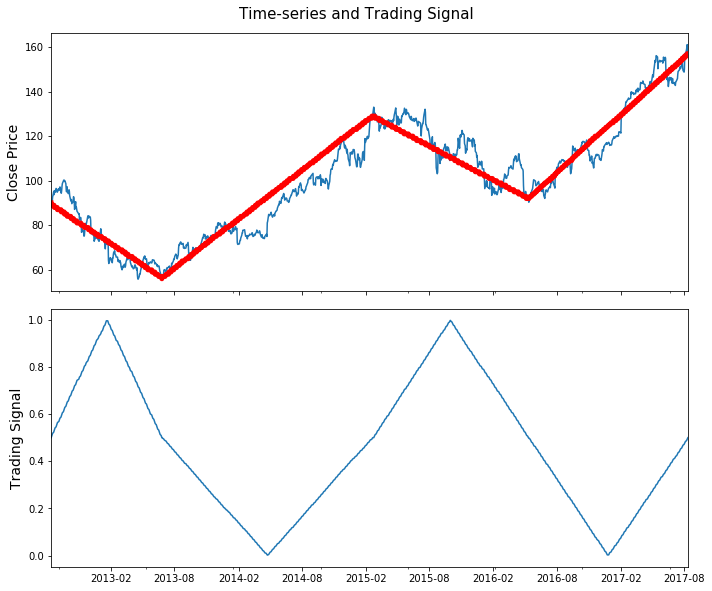

In [145]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex= True, figsize = (10, 8))
fig.suptitle("Time-series and Trading Signal", y = 1.02, size = 15)
xx = np.arange(len(close))
#ax1.plot(piece, c = "red")
apple["Close"].plot(ax = ax1 )
ax1.set_ylabel("Close Price", size = 14)

EPSILON = 15
piece, lines, points = PLR(close, EPSILON)
ax1.plot(apple.index, piece, c = "red", linewidth = 5, label = "PLR (threshold 20)")

ts= trading_signal(close, EPSILON)
ax2.plot(apple.index, ts)
ax2.set_ylabel("Trading Signal", size = 14)

plt.tight_layout()